# MLP Training with Nabla: Acceleration Modes Tutorial

This tutorial demonstrates training a Multi-Layer Perceptron using **three different execution modes** in Nabla:

1. **🐢 Eager Mode** - Direct execution of each operation, best for debugging
2. **🏃 Dynamic JIT (nabla.djit)** - Deferred execution, can handle data-dependent cond. statements in a program
3. **🚀 Static JIT (nabla.jit)** - Maximum performance, assumes static programs

**Learning Goal**: Understand the performance trade-offs and when to use each mode.

**Problem**: Train an MLP to learn `f(x) = sin(8 * 2π * x) / 2 + 0.5` - a complex 8-period sine function.

In [1]:
# Installation
import sys

IN_COLAB = "google.colab" in sys.modules

try:
    import nabla as nb
except ImportError:
    import subprocess

    subprocess.run(
        [
            sys.executable,
            "-m",
            "pip",
            "install",
            "modular",
            "--extra-index-url",
            "https://download.pytorch.org/whl/cpu",
            "--index-url",
            "https://dl.modular.com/public/nightly/python/simple/",
        ],
        check=True,
    )
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "nabla-ml", "--upgrade"], check=True
    )
    import nabla as nb

# Import other required libraries
import matplotlib.pyplot as plt
import numpy as np

print(
    f"🎉 Nabla is ready! Running on Python {sys.version_info.major}.{sys.version_info.minor}"
)

🎉 Nabla is ready! Running on Python 3.12


In [3]:
# Configuration parameters
BATCH_SIZE = 128
LAYERS = [1, 64, 128, 256, 128, 64, 1]  # MLP architecture
LEARNING_RATE = 0.001
NUM_EPOCHS = 5000
PRINT_INTERVAL = 1000
SIN_PERIODS = 8

# Set random seed for reproducibility
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

## 2. Core Model and Utility Functions

Let's define the essential functions for our neural network and training process.

In [4]:
def mlp_forward(x: nb.Array, params: list[nb.Array]) -> nb.Array:
    """Forward pass of the MLP with ReLU activations."""
    output = x
    for i in range(0, len(params) - 1, 2):
        w, b = params[i], params[i + 1]
        output = nb.matmul(output, w) + b
        if i < len(params) - 2:  # No ReLU for the output layer
            output = nb.relu(output)
    return output


def mean_squared_error(predictions: nb.Array, targets: nb.Array) -> nb.Array:
    """Compute mean squared error loss."""
    diff = predictions - targets
    squared_errors = diff * diff
    batch_size = nb.array(predictions.shape[0], dtype=nb.DType.float32)
    return nb.sum(squared_errors) / batch_size


def create_sin_dataset(batch_size: int = BATCH_SIZE) -> tuple[nb.Array, nb.Array]:
    """Generate training data for the sinusoidal function."""
    x = nb.rand((batch_size, 1), lower=0.0, upper=1.0, dtype=nb.DType.float32)
    targets = nb.sin(SIN_PERIODS * 2.0 * np.pi * x) / 2.0 + 0.5
    return x, targets


def initialize_for_complex_function(
    layers: list[int], seed: int = GLOBAL_SEED
) -> list[nb.Array]:
    """Initialize weights using He Normal initialization."""
    params = []
    for i in range(len(layers) - 1):
        fan_in, fan_out = layers[i], layers[i + 1]
        w = nb.he_normal((fan_in, fan_out), seed=seed)
        b = nb.zeros((fan_out,))
        params.extend([w, b])
    return params


def adamw_step(
    params: list[nb.Array],
    gradients: list[nb.Array],
    m_states: list[nb.Array],
    v_states: list[nb.Array],
    step: int,
    learning_rate: float = LEARNING_RATE,
    beta1: float = 0.9,
    beta2: float = 0.999,
    eps: float = 1e-8,
    weight_decay: float = 0.01,
) -> tuple[list[nb.Array], list[nb.Array], list[nb.Array]]:
    """AdamW optimization step with weight decay."""
    updated_params, updated_m, updated_v = [], [], []
    bc1, bc2 = 1.0 - beta1**step, 1.0 - beta2**step

    for param, grad, m, v in zip(params, gradients, m_states, v_states, strict=False):
        new_m = beta1 * m + (1.0 - beta1) * grad
        new_v = beta2 * v + (1.0 - beta2) * (grad * grad)
        m_corrected = new_m / bc1
        v_corrected = new_v / bc2
        update = m_corrected / (v_corrected**0.5 + eps) + weight_decay * param
        new_param = param - learning_rate * update
        updated_params.append(new_param)
        updated_m.append(new_m)
        updated_v.append(new_v)

    return updated_params, updated_m, updated_v


def init_adamw_state(params: list[nb.Array]) -> tuple[list[nb.Array], list[nb.Array]]:
    """Initialize AdamW optimizer states."""
    m_states = [nb.zeros_like(param) for param in params]
    v_states = [nb.zeros_like(param) for param in params]
    return m_states, v_states


def learning_rate_schedule(
    epoch: int,
    initial_lr: float = LEARNING_RATE,
    decay_factor: float = 0.95,
    decay_every: int = 1000,
) -> float:
    """Learning rate decay schedule."""
    return initial_lr * (decay_factor ** (epoch // decay_every))


def _loss_fn(x: nb.Array, targets: nb.Array, params: list[nb.Array]) -> nb.Array:
    """Helper function for loss computation used with value_and_grad."""
    return mean_squared_error(mlp_forward(x, params), targets)


def compute_predictions_and_loss(
    x_test: nb.Array, targets_test: nb.Array, params: list[nb.Array]
) -> tuple[nb.Array, nb.Array]:
    """Compute predictions and loss for evaluation."""
    predictions_test = mlp_forward(x_test, params)
    test_loss = mean_squared_error(predictions_test, targets_test)
    return predictions_test, test_loss

## 3. Training Step Implementations

Now let's implement the training step for each execution mode. The key difference is how Nabla compiles and executes the computational graph.

### About `value_and_grad`
The `value_and_grad` function is a fundamental transformation in Nabla (similar to JAX). It takes a function and returns a new function that computes both the original function's value and its gradient with respect to specified arguments. This is crucial for training neural networks as it allows us to compute the loss and its gradients in a single pass.

In [5]:
def train_step_no_jit(
    x: nb.Array,
    targets: nb.Array,
    params: list[nb.Array],
    m_states: list[nb.Array],
    v_states: list[nb.Array],
    step: int,
    learning_rate: float,
) -> tuple[list[nb.Array], list[nb.Array], list[nb.Array], nb.Array]:
    """Training step in eager mode (no JIT compilation)."""
    # Compute loss and gradients using value_and_grad
    loss_value, param_gradients = nb.value_and_grad(
        lambda *p: _loss_fn(x, targets, p), argnums=list(range(len(params)))
    )(*params)

    # Update parameters using AdamW
    updated_params, updated_m, updated_v = adamw_step(
        params, param_gradients, m_states, v_states, step, learning_rate
    )

    return updated_params, updated_m, updated_v, loss_value


@nb.djit
def train_step_djit(
    x: nb.Array,
    targets: nb.Array,
    params: list[nb.Array],
    m_states: list[nb.Array],
    v_states: list[nb.Array],
    step: int,
    learning_rate: float,
) -> tuple[list[nb.Array], list[nb.Array], list[nb.Array], nb.Array]:
    """Training step with dynamic JIT compilation."""
    loss_value, param_gradients = nb.value_and_grad(
        lambda *p: _loss_fn(x, targets, p), argnums=list(range(len(params)))
    )(*params)

    updated_params, updated_m, updated_v = adamw_step(
        params, param_gradients, m_states, v_states, step, learning_rate
    )

    return updated_params, updated_m, updated_v, loss_value


@nb.jit
def train_step_jit(
    x: nb.Array,
    targets: nb.Array,
    params: list[nb.Array],
    m_states: list[nb.Array],
    v_states: list[nb.Array],
    step: int,
    learning_rate: float,
) -> tuple[list[nb.Array], list[nb.Array], list[nb.Array], nb.Array]:
    """Training step with static JIT compilation."""
    loss_value, param_gradients = nb.value_and_grad(
        lambda *p: _loss_fn(x, targets, p), argnums=list(range(len(params)))
    )(*params)

    updated_params, updated_m, updated_v = adamw_step(
        params, param_gradients, m_states, v_states, step, learning_rate
    )

    return updated_params, updated_m, updated_v, loss_value

## 4. Experiment Runner

Let's create a function to run our training experiments and collect results.

In [6]:
def run_training_experiment(train_step_func, jit_mode: str):
    """Run training experiment and collect results."""
    print(f"\n{'=' * 50}\nStarting Training with: {jit_mode}\n{'=' * 50}")
    print(f"Architecture: {LAYERS}")
    print(f"Initial Learning Rate: {LEARNING_RATE}")

    # Initialize model and optimizer
    params = initialize_for_complex_function(LAYERS, seed=GLOBAL_SEED)
    m_states, v_states = init_adamw_state(params)

    # Initial evaluation
    x_init, targets_init = create_sin_dataset(BATCH_SIZE)
    predictions_init = mlp_forward(x_init, params)
    initial_loss = mean_squared_error(predictions_init, targets_init).to_numpy().item()
    print(f"Initial Loss: {initial_loss:.6f}")

    # Training loop
    avg_loss, total_time, compile_time = 0.0, 0.0, 0.0
    print("Starting training loop...")

    for epoch in range(1, NUM_EPOCHS + 1):
        epoch_start = time.time()
        current_lr = learning_rate_schedule(epoch)
        x, targets = create_sin_dataset(BATCH_SIZE)

        if "JIT" in jit_mode and epoch == 1:
            compile_start = time.time()
            updated_params, updated_m, updated_v, loss_value = train_step_func(
                x, targets, params, m_states, v_states, epoch, current_lr
            )
            compile_time = time.time() - compile_start
        else:
            updated_params, updated_m, updated_v, loss_value = train_step_func(
                x, targets, params, m_states, v_states, epoch, current_lr
            )

        params, m_states, v_states = updated_params, updated_m, updated_v
        avg_loss += loss_value.to_numpy().item()
        total_time += time.time() - epoch_start

        if epoch % PRINT_INTERVAL == 0:
            print(f"Epoch {epoch:4d} | Avg Loss: {avg_loss / PRINT_INTERVAL:.6f}")
            avg_loss = 0.0

    # Final evaluation
    x_test = nb.Array.from_numpy(
        np.linspace(0, 1, 1000).reshape(-1, 1).astype(np.float32)
    )
    targets_test = nb.Array.from_numpy(
        (np.sin(SIN_PERIODS * 2.0 * np.pi * x_test.to_numpy()) / 2.0 + 0.5).astype(
            np.float32
        )
    )
    predictions_test, test_loss = compute_predictions_and_loss(
        x_test, targets_test, params
    )
    final_loss = test_loss.to_numpy().item()
    correlation = np.corrcoef(
        predictions_test.to_numpy().flatten(), targets_test.to_numpy().flatten()
    )[0, 1]

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(
        x_test.to_numpy(), targets_test.to_numpy(), label="True Function", color="blue"
    )
    plt.plot(
        x_test.to_numpy(),
        predictions_test.to_numpy(),
        label="Predictions",
        color="red",
        linestyle="--",
    )
    plt.title(f"{jit_mode} Results")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return results
    avg_epoch_time = (
        (total_time - compile_time) / (NUM_EPOCHS - 1)
        if "JIT" in jit_mode
        else total_time / NUM_EPOCHS
    )
    return {
        "mode": jit_mode,
        "total_time": total_time,
        "compile_time": compile_time,
        "avg_epoch_time": avg_epoch_time,
        "final_loss": final_loss,
        "correlation": correlation,
    }

## 5. Run Experiments and Compare Results

Now let's run our experiments with different execution modes and compare the results.


Running Eager Mode Experiment...

Starting Training with: Eager Mode (No JIT)
Architecture: [1, 64, 128, 256, 128, 64, 1]
Initial Learning Rate: 0.001
Initial Loss: 1.839083
Starting training loop...
Epoch 1000 | Avg Loss: 0.103540
Epoch 2000 | Avg Loss: 0.078370
Epoch 3000 | Avg Loss: 0.054682
Epoch 4000 | Avg Loss: 0.022529
Epoch 5000 | Avg Loss: 0.014815


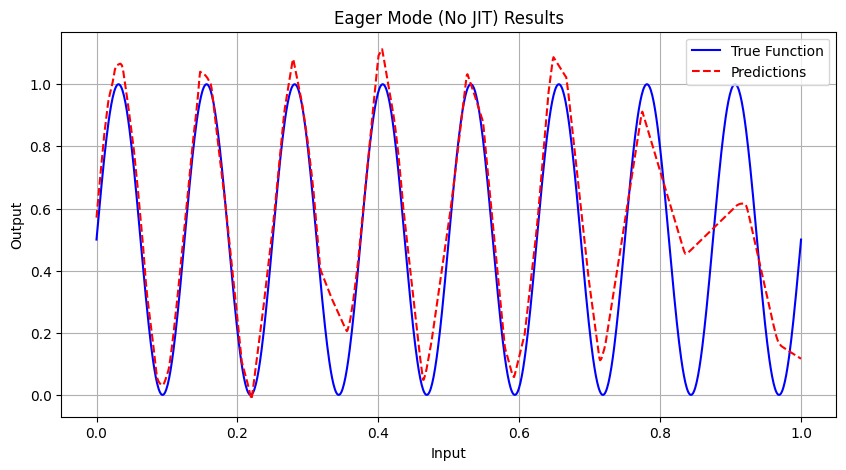


Running Dynamic JIT Experiment...

Starting Training with: Dynamic JIT (nb.djit)
Architecture: [1, 64, 128, 256, 128, 64, 1]
Initial Learning Rate: 0.001
Initial Loss: 1.839083
Starting training loop...
Epoch 1000 | Avg Loss: 0.102841
Epoch 2000 | Avg Loss: 0.076053
Epoch 3000 | Avg Loss: 0.042250
Epoch 4000 | Avg Loss: 0.017627
Epoch 5000 | Avg Loss: 0.007438


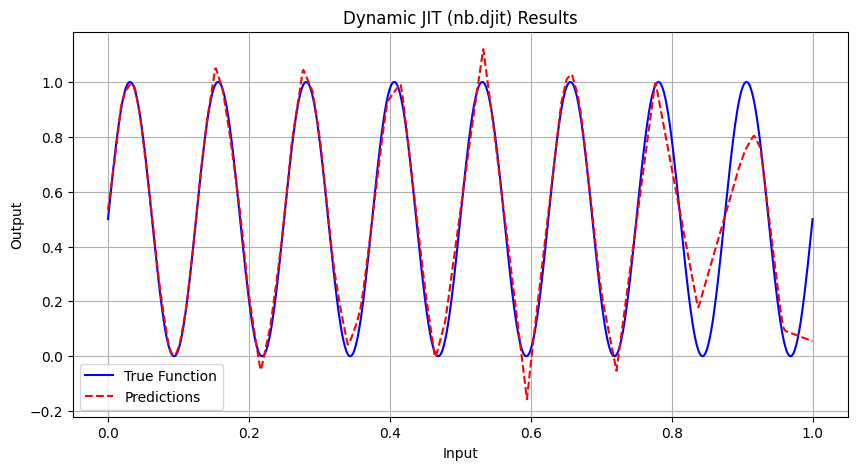


Running Static JIT Experiment...

Starting Training with: Static JIT (nb.jit)
Architecture: [1, 64, 128, 256, 128, 64, 1]
Initial Learning Rate: 0.001
Initial Loss: 1.839083
Starting training loop...
Epoch 1000 | Avg Loss: 0.106225
Epoch 2000 | Avg Loss: 0.087544
Epoch 3000 | Avg Loss: 0.060891
Epoch 4000 | Avg Loss: 0.031402
Epoch 5000 | Avg Loss: 0.013393


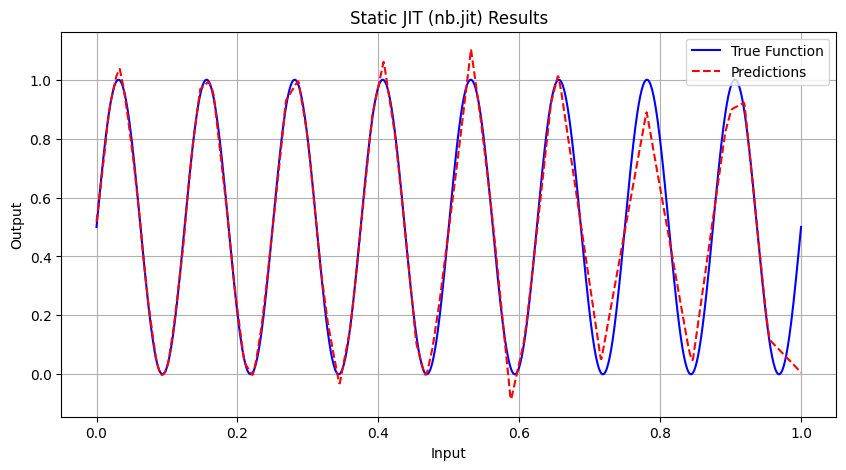



                        NABLA JIT PERFORMANCE COMPARISON                        
Mode                      | Total Time (s)  | Avg Epoch Time (s) | Final Loss | Correlation
--------------------------------------------------------------------------------
Eager Mode (No JIT)       | 25.1912         | 0.005036           | 0.019939   | 0.9313    
Dynamic JIT (nb.djit)     | 23.8807         | 0.004753           | 0.006162   | 0.9759    
Static JIT (nb.jit)       | 3.5819          | 0.000688           | 0.004731   | 0.9818    


In [7]:
# Run experiments
results = []

print("\nRunning Eager Mode Experiment...")
results.append(run_training_experiment(train_step_no_jit, "Eager Mode (No JIT)"))

print("\nRunning Dynamic JIT Experiment...")
results.append(run_training_experiment(train_step_djit, "Dynamic JIT (nb.djit)"))

print("\nRunning Static JIT Experiment...")
results.append(run_training_experiment(train_step_jit, "Static JIT (nb.jit)"))

# Display results comparison
print("\n\n" + "=" * 80)
print("NABLA JIT PERFORMANCE COMPARISON".center(80))
print("=" * 80)
print(
    f"{'Mode':<25} | {'Total Time (s)':<15} | {'Avg Epoch Time (s)':<18} | {'Final Loss':<10} | {'Correlation':<10}"
)
print("-" * 80)

for res in results:
    print(
        f"{res['mode']:<25} | {res['total_time']:<15.4f} | {res['avg_epoch_time']:<18.6f} | {res['final_loss']:<10.6f} | {res['correlation']:<10.4f}"
    )

## 6. Analysis and Conclusions

Based on the results, we can draw the following conclusions:

- Static JIT (`nb.jit`) is the fastest after compilation
- Dynamic JIT (`nb.djit`) offers a good balance between flexibility and performance
- Eager mode is the slowest but most flexible for debugging

### Recommendations:

- Use `nb.jit` for production training with static graphs
- Use `nb.djit` when you need some flexibility in your computation graph
- Use eager mode for debugging and development